# Traffic Volume
![](img/9259.jpg)

{octicon}`calendar` Aug, 2025 

## Background
Many local businesses in my town close in mid-August to coincide with their customers' holidays. This inspired the idea of creating a predictive model to determine the optimal time for such closures based on seasonal population changes. My search for relevant open data on public attendance only yielded traffic information. Though not ideal, I decided this data would be a sufficient proxy for the modeling exercise.

## The data
I sourced weekly traffic volume data for 2021-2025 from [Gipuzkoa Irekia](https://www.gipuzkoairekia.eus/es/datu-irekien-katalogoa) and the corresponding holiday calendars from [Opendata Euskadi](https://opendata.euskadi.eus/catalogo).

Using a Python [script](scripts/read_volumentrafico.py), I processed traffic CSV files to extract __daily__ data for a single measurement point (number 9259) at coordinates (43.072638, -2.330442). For this location, I simply aggregated the vehicle volume, without breaking it down by more granular details like hourly data, direction-lane, or vehicle type (light-heavy).

![](img/9259_map.jpg)

Regarding the [calendars](scripts/read_calendarios.py), I took bank holidays for Euskadi and Gipuzkoa, not considering local festivities as an initial approach.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Read data
trafikoa = pd.read_csv("data/trafikoa.csv",
                       parse_dates=["Fecha"], index_col="Fecha")
trafikoa

,volume
Fecha,
2021-01-04,6929
2021-01-05,7398
2021-01-06,3466
2021-01-07,9676
2021-01-08,9781
...,...
2025-07-23,10831
2025-07-24,10627
2025-07-25,4769


Let's check missing data (days without measurement).

In [2]:
# Create full date range from min to max date
data_range = pd.date_range(start=trafikoa.index.min(),
                           end=trafikoa.index.max(), freq='D')

# Find missing dates
missing_dates = data_range.difference(trafikoa.index)

print(f"Missing {len(missing_dates)} out of {len(data_range)} days\
({100 * len(missing_dates) / len(data_range):.0f}%)")
print(f"\nMissing days -> {missing_dates}")

Missing 27 out of 1666 days(2%)

Missing days -> DatetimeIndex(['2022-02-04', '2022-02-05', '2022-02-06', '2024-03-13',
               '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17',
               '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02',
               '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06',
               '2024-05-07', '2024-11-18', '2024-11-19', '2024-11-20',
               '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24',
               '2024-12-16', '2024-12-17', '2025-04-09'],
              dtype='datetime64[ns]', freq=None)


I will reindex the dataframe to cover the full daily calendar from 2021 to 2025, leaving missing values in place for exploratory analysis, since they do not affect the average calculations.

In [3]:
trafikoa = trafikoa.reindex(pd.date_range(start="2021-01-01",
                                          end="2025-12-31", freq="D"))
trafikoa

,volume
2021-01-01,NaN
2021-01-02,NaN
2021-01-03,NaN
2021-01-04,6929.0
2021-01-05,7398.0
...,...
2025-12-27,NaN
2025-12-28,NaN
2025-12-29,NaN
2025-12-30,NaN


## Exploratory analysis

### Trend

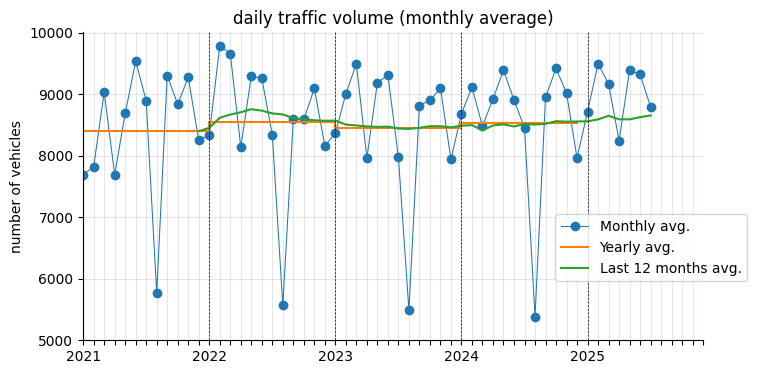

In [4]:
# Resample monthly
monthly = trafikoa.resample("MS").mean()

# Resample yearly
yearly = trafikoa.resample("YS").mean()
yearly_step = yearly.resample("MS").ffill() # Stepwise, for plotting
yearly_step = yearly_step[yearly_step.index.year < 2025]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

monthly.plot(ax=ax, marker="o", linewidth=0.75)
yearly_step.plot(ax=ax, drawstyle="steps-post")
window = 12
monthly.rolling(window=window).mean().plot(ax=ax)

ax.grid(axis="x", alpha=0.3)
ax.grid(axis="y", alpha=0.3)
ax.set_ylabel("number of vehicles")
ax.set_title("daily traffic volume (monthly average)")
ax.set_xticks(monthly.index)
ax.set_yticks(range(5000, 11000, 1000))
for i in range(2022, 2026):
    ax.axvline(f"{i}", linestyle="--", color="black", linewidth=0.5)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h, labels=["Monthly avg.",
                             "Yearly avg.",
                             f"Last {window} months avg."],
          bbox_to_anchor=(0.75, 0.3), loc="center left")
sns.despine()
plt.show()

As expected, the data shows a clear 12-month seasonality. While yearly averages appear fairly stationary, the monthly moving average indicates a slight upward trend in recent months.

The augmented Dickey-Fuller test confirms that the monthly series is not stationary.

In [5]:
result = adfuller(monthly.dropna())
stationary = bool(result[0] <= result[4]["5%"])
print(f"Monthly trend stationary? {stationary}")

Monthly trend stationary? False


### By month

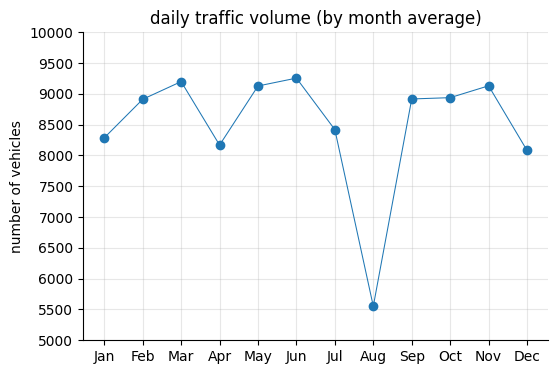

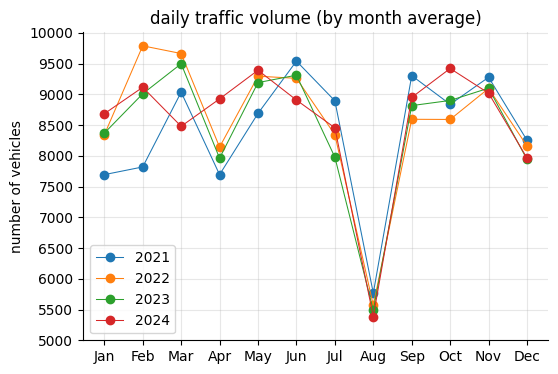

In [6]:
# Only complete years for by-month and by-dayofweek plots
trafikoa24 = trafikoa[trafikoa.index.year < 2025]

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

bymonth = trafikoa24.groupby(trafikoa24.index.month)["volume"].mean()
bymonth.plot(ax=ax, marker="o", linewidth=0.75)

ax.grid(axis="both", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.set_ylabel("number of vehicles")
ax.set_title("daily traffic volume (by month average)")
ax.set_xticks(range(1, 13),
              labels=[calendar.month_abbr[month] for month in range(1, 13)])
ax.set_yticks(range(5000, 10500, 500))
sns.despine()
plt.show()

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

monthly24 = trafikoa24.resample("MS").mean()
for year in range(2021, 2025):
    monthly24_year = monthly24[monthly24.index.year == year]
    # groupby month for the index to have range(1, 13)
    monthly24_year = monthly24_year.groupby(monthly24_year.index.month)["volume"].mean()
    monthly24_year.plot(ax=ax, marker="o", linewidth=0.75, label=year)

ax.grid(axis="both", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.set_ylabel("number of vehicles")
ax.set_title("daily traffic volume (by month average)")
ax.set_xticks(range(1, 13),
              labels=[calendar.month_abbr[month] for month in range(1, 13)])
ax.set_yticks(range(5000, 10500, 500))
ax.legend()
sns.despine()
plt.show()

As expected, traffic volume drops in August. Across the years, there appears to be a post-pandemic effect in early 2021, with slightly lower traffic levels.

### By day of the week

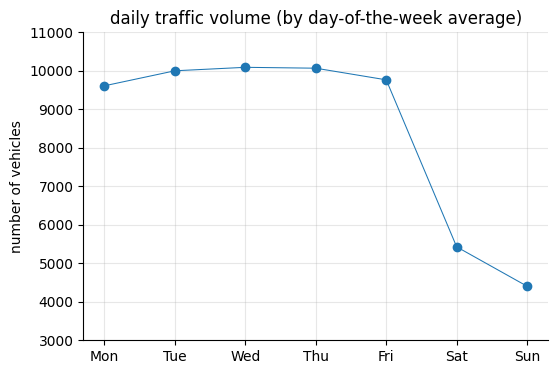

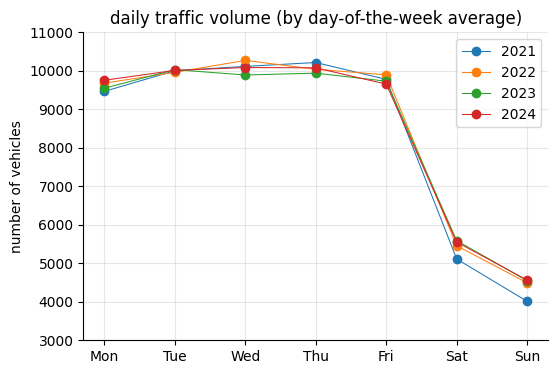

In [7]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))

byday = trafikoa24.groupby(trafikoa24.index.dayofweek)["volume"].mean()
byday.plot(ax=ax, marker="o", linewidth=0.75)

ax.grid(axis="both", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.set_ylabel("number of vehicles")
ax.set_title("daily traffic volume (by day-of-the-week average)")
ax.set_xticks(range(7), labels=list(calendar.day_abbr))
ax.set_yticks(range(3000, 12000, 1000))
sns.despine()
plt.show()

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

for year in range(2021, 2025):
    trafikoa24_year = trafikoa24[trafikoa24.index.year == year]
    byday_year = trafikoa24_year.groupby(trafikoa24_year.index.dayofweek)["volume"].mean()
    byday_year.plot(ax=ax, marker="o", linewidth=0.75, label=year)

ax.grid(axis="both", alpha=0.3)
ax.set_axisbelow(True)
ax.set_xlabel("")
ax.set_ylabel("number of vehicles")
ax.set_title("daily traffic volume (by day-of-the-week average)")
ax.set_xticks(range(7), labels=list(calendar.day_abbr))
ax.set_yticks(range(3000, 12000, 1000))
ax.legend()
sns.despine()
plt.show()

A noticeable difference also appears in 2021, likely due to the pandemic.

## Modelling
Two approaches are possible:
1. __Simple Classical Model__ (e.g., Linear Regression with Features)
2. __Time Series-Focused Model__ (e.g., Seasonal ARIMA with External Factors)

(1) treats the problem as a standard regression task. As I know that the traffic volume depends heavily on the day of the week, month of the year, holidays and other forseeable half-holiday or special days, I can prepare this information as features. Traffic patterns are often explainable by these calendar-based factors, and linear regression can capture linear relationships efficiently.

(2) emphasizes the sequential, autocorrelated nature of the data (e.g., today's traffic influences tomorrow's). It has these components: AR (AutoRegressive): Captures dependence on past values; I (Integrated): Differences the data to make it stationary (e.g., remove trends); MA (Moving Average): Models error terms from past forecasts; Seasonal terms: Handle repeating patterns like weekly (period=7 for daily data) or yearly (period=365) cycles. Traffic data is inherently a time series with strong autocorrelation (e.g., high traffic on Fridays persists week to week) and seasonality, which SARIMA(X) is designed to model directly without manual lag engineering.

ARIMA-based models often outperform simple linear regression for time series like traffic volume, especially when seasonality is prominent, because linear regression assumes independence between observations—which is violated in time series data.

However, as the data lacks strong trends and has minimal autocorrelation, linear regression is much simpler and could be just enough. It also more interpretable.

### Features
I will just build these features, which clearly affect the traffic volume:
- Month of the year, January to December: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
- Day of the week, Monday to Sunday: (0, 1, 2, 3, 4, 5, 6)
- Holidays
- Half-holidays

In [8]:
trafikoa["dayofweek"] = trafikoa.index.dayofweek
trafikoa["month"] = trafikoa.index.month
trafikoa[3:10]

,volume,dayofweek,month
2021-01-04,6929.0,0,1
2021-01-05,7398.0,1,1
2021-01-06,3466.0,2,1
2021-01-07,9676.0,3,1
2021-01-08,9781.0,4,1
2021-01-09,3445.0,5,1
2021-01-10,2334.0,6,1


I will get holidays from the official calendar data.

In [9]:
# Read holiday data
festak = pd.read_csv("data/festak.csv",
                     parse_dates=["date"], index_col="date")
festak

,holiday
date,
2021-01-01,1
2021-01-06,1
2021-03-19,1
2021-04-01,1
2021-04-02,1
...,...
2025-11-01,1
2025-12-06,1
2025-12-08,1


In [10]:
trafikoa = trafikoa.join(festak)
trafikoa = trafikoa.fillna(value={"holiday": 0}).astype({"holiday": "int32"})
trafikoa.head()

,volume,dayofweek,month,holiday
2021-01-01,NaN,4,1,1
2021-01-02,NaN,5,1,0
2021-01-03,NaN,6,1,0
2021-01-04,6929.0,0,1,0
2021-01-05,7398.0,1,1,0


Half-holidays considered are days that are not weekend days nor holidays, and:
- previous day is holiday and next day is weekend
- previous day is weekend and next day is holiday
- previous day is holiday and next day is holiday
- is 24th December
- is 31th December

In [11]:
# Boolean masks
is_holiday = trafikoa["holiday"] == 1
is_weekend = trafikoa["dayofweek"].isin([5, 6])

# Check if previous day is holiday and next day is weekend
cond1 = is_holiday.shift(1) & is_weekend.shift(-1) & (~is_holiday) & (~is_weekend)

# Check if previous day is weekend and next day is holiday
cond2 = is_weekend.shift(1) & is_holiday.shift(-1) & (~is_holiday) & (~is_weekend)

# Check if previous day is holiday and next day is holiday
cond3 = is_holiday.shift(1) & is_holiday.shift(-1) & (~is_holiday) & (~is_weekend)

# Check if 24 dec and not weekend
cond4 = (trafikoa.index.month == 12) & (trafikoa.index.day == 24) & (~is_weekend)

# Check if 31 dec and not weekend
cond5 = (trafikoa.index.month == 12) & (trafikoa.index.day == 31) & (~is_weekend)

trafikoa["half_holiday"] = (cond1 | cond2 | cond3 | cond4 | cond5).astype("int32")

print(trafikoa.info())
trafikoa

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2021-01-01 to 2025-12-31
Freq: D
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   volume        1639 non-null   float64
 1   dayofweek     1826 non-null   int32  
 2   month         1826 non-null   int32  
 3   holiday       1826 non-null   int32  
 4   half_holiday  1826 non-null   int32  
dtypes: float64(1), int32(4)
memory usage: 57.1 KB
None


,volume,dayofweek,month,holiday,half_holiday
2021-01-01,NaN,4,1,1,0
2021-01-02,NaN,5,1,0,0
2021-01-03,NaN,6,1,0,0
2021-01-04,6929.0,0,1,0,0
2021-01-05,7398.0,1,1,0,0
...,...,...,...,...,...
2025-12-27,NaN,5,12,0,0
2025-12-28,NaN,6,12,0,0
2025-12-29,NaN,0,12,0,0
2025-12-30,NaN,1,12,0,0


### Linear Regression
Data from 2021, 2022, and 2023 will be used to train the model. The year 2024 will be reserved for testing its performance. Finally, the (incomplete) 2025 data will be used for validation.
#### Test 2024

In [12]:
# Define features and target dropping missing-value rows
features = trafikoa.dropna()[["dayofweek", "month", "holiday", "half_holiday"]]
target = trafikoa.dropna()["volume"]

# Hot-encoding: they're categorical even if numbered!
y = target
X = pd.get_dummies(features, columns=["dayofweek", "month"], dtype="int32")

# Split data
X_train = X[X.index.year < 2024]
y_train = y[y.index.year < 2024]
X_test = X[X.index.year == 2024]
y_test = y[y.index.year == 2024]

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r_squared = model.score(X_test, y_test)
rmse = root_mean_squared_error(y_test, y_pred)

print("Model score:")
print(f"\tR^2 -> {r_squared:.2f}")
print(f"\tRMSE -> {rmse:.0f}")

Model score:
	R^2 -> 0.91
	RMSE -> 846


The model’s performance appears reasonably good, with an average error of fewer than 1,000 vehicles—roughly under 10% of the daily traffic volume (about 10,000 vehicles).

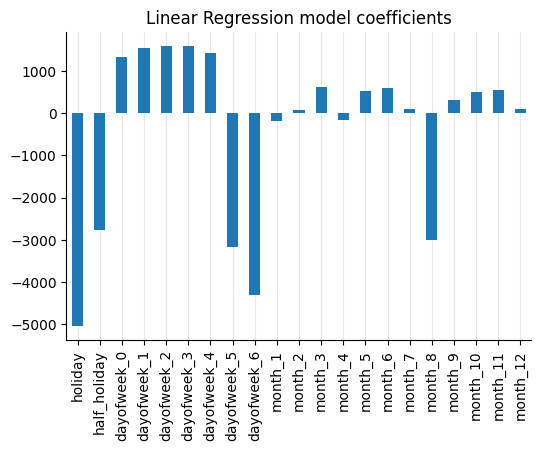

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))
pd.DataFrame(model.coef_, index=X.columns).plot(ax=ax, kind="bar")
ax.grid(axis="x", alpha=0.3)
ax.set_axisbelow(True)
ax.set_title("Linear Regression model coefficients")
sns.despine()
ax.legend().remove()
plt.show()

As expected, holidays, partial holidays, weekends, and the month of August have a greater impact than the other variables.

Once we have the model, we can make the prediction through the whole 2024 calendar.

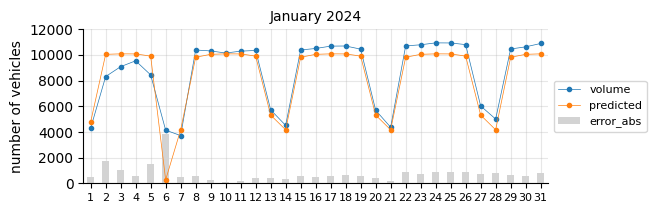

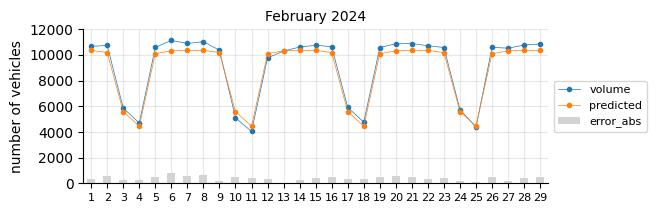

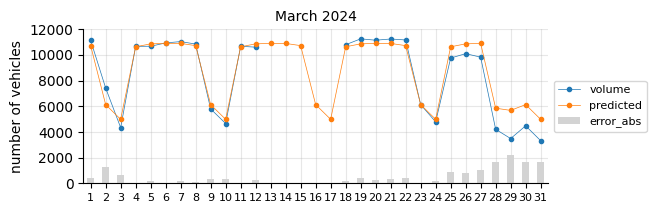

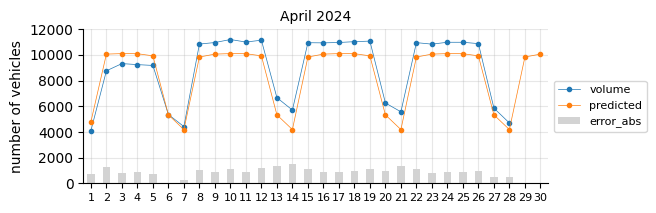

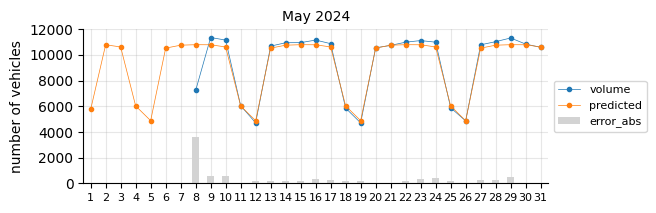

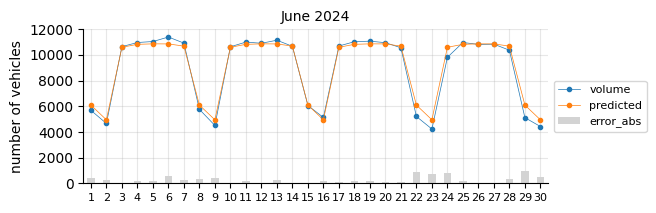

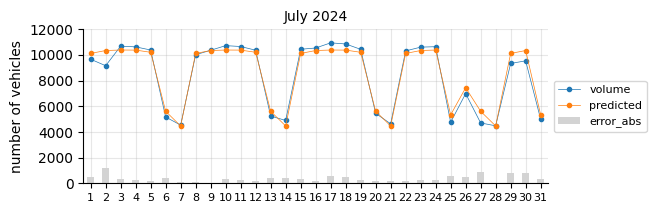

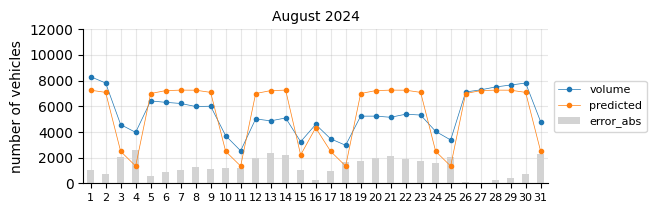

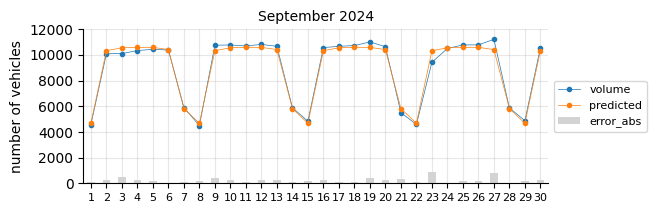

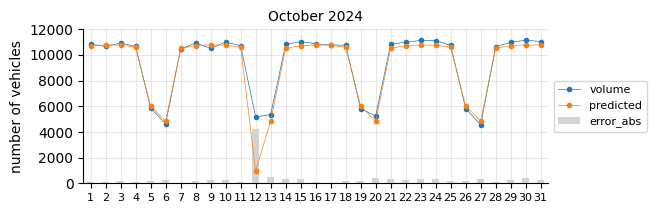

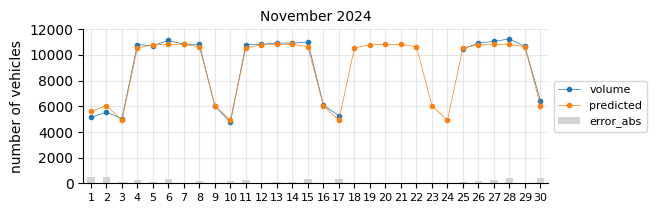

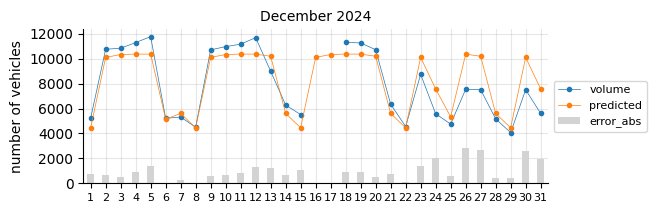

In [14]:
# Predict the whole calendar year
X_all = pd.get_dummies(trafikoa[["dayofweek", "month", "holiday", "half_holiday"]],
                        columns=["dayofweek", "month"], dtype="int32")
X_24 = X_all[X_all.index.year == 2024]
y_pred24 = model.predict(X_24)

# Create dataframe from array
y_pred24_df = pd.DataFrame(y_pred24,
                           columns=["predicted"],
                           index=X_24.index)
# Join
pred24 = trafikoa.loc[trafikoa.index.year == 2024, ["volume"]].join(y_pred24_df)

# Claculate prediction error
pred24["error"] =  pred24["predicted"] - pred24["volume"]
pred24["error_abs"] =  abs(pred24["error"])

# Plot
for month in range(1, 13):
    fig, ax = plt.subplots(figsize=(6, 2))
    pred24_month = pred24[pred24.index.month == month]
    pred24_month = pred24_month.set_index(pred24_month.index.day)
    pred24_month[["volume", "predicted"]].reset_index(drop=True).plot(ax=ax, marker=".", linewidth=0.5)
    pred24_month[["error_abs"]].plot(ax=ax, kind="bar", color="lightgrey")
    ax.grid(axis="both", alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_title(calendar.month_name[month] + " 2024", size=10)
    ax.set_xlabel("")
    ax.set_ylabel("number of vehicles")
    ax.set_yticks(range(0, 13000, 2000))
    ax.tick_params(axis='x', labelsize=8, rotation=0)
    ax.legend(fontsize=8, bbox_to_anchor=(1.00, 0.5), loc="center left")
    sns.despine()
    plt.show()

The model predicts fairly well considering its simplicity.

The prediction model struggles in August, likely due to the limitations of a linear model in capturing such pronounced seasonal pattern changes.

In general, for most days the predictions fall below the actual values, which may indicate two things:
1. The 2021 training data was still affected by the pandemic, leading to lower traffic levels.
2. There is a slight upward trend that the features fail to capture.

To account for the recent upward trend, a time-related feature should be added—an indicator that informs the model of this effect, which a time-based model would inherently capture.

#### Prediction 2025
I will retrain the Logistic Regression model, excluding 2021 and including 2024, to forecast the entire 2025 calendar year. At this stage of the project, only data through August is available for performance evaluation.

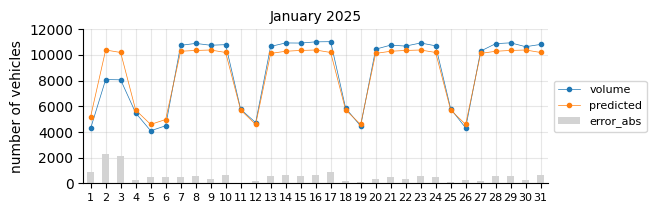

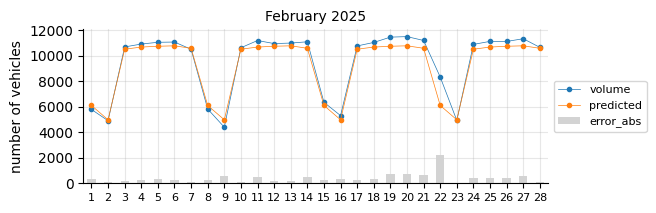

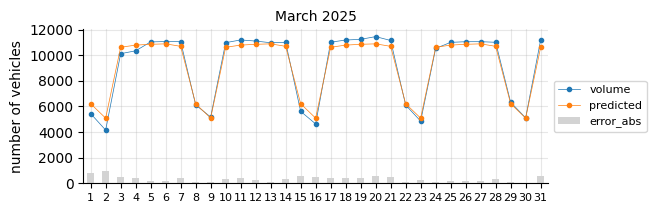

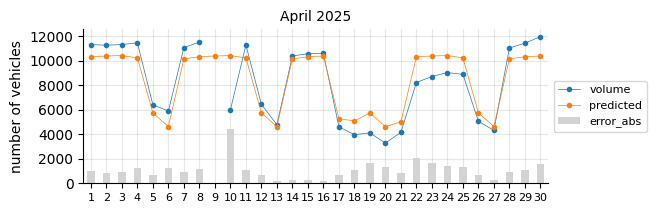

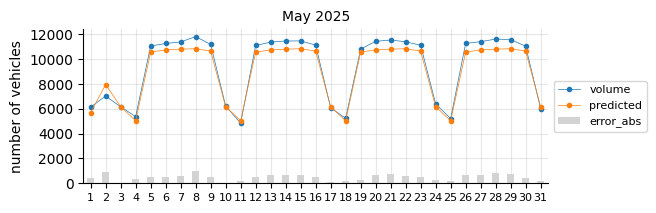

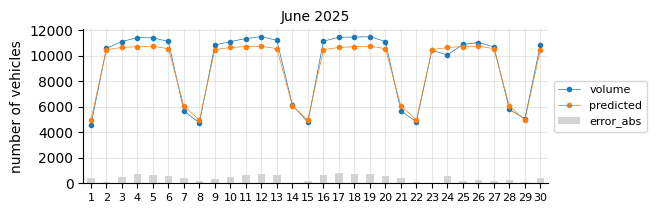

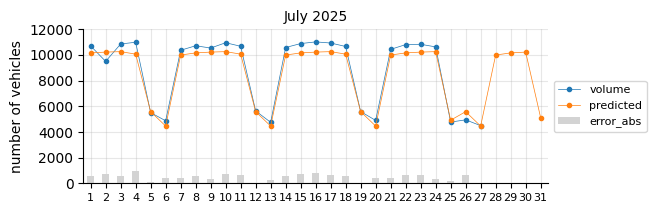

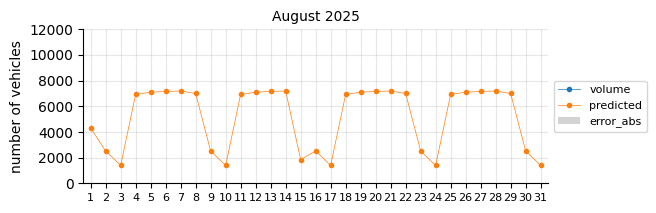

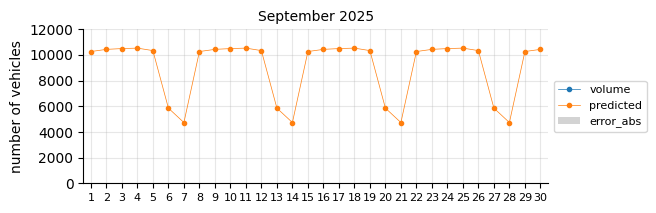

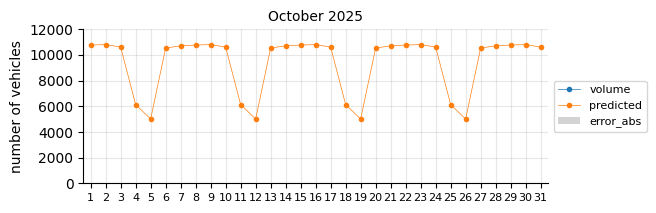

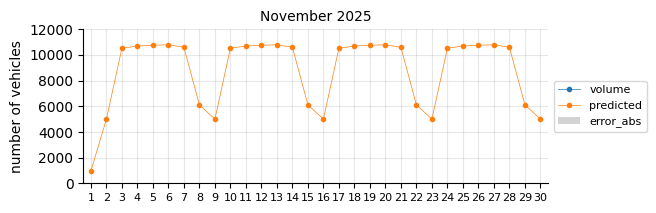

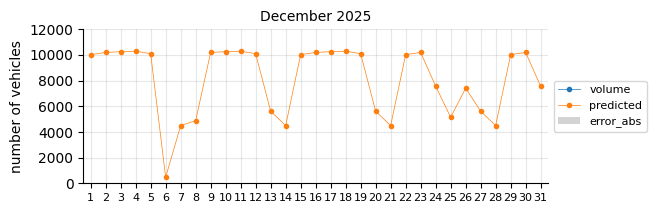

In [15]:
# Split data, dismiss 2021
X_train = X[(X.index.year < 2025) & (X.index.year > 2021)]
y_train = y[(y.index.year < 2025) & (X.index.year > 2021)]

# Fit model
model.fit(X_train, y_train)

# Predict the whole calendar year
X_25 = X_all[X_all.index.year == 2025]
y_pred25 = model.predict(X_25)

# Create dataframe from array
y_pred25_df = pd.DataFrame(y_pred25,
                           columns=["predicted"],
                           index=X_25.index)
# Join
pred25 = trafikoa.loc[trafikoa.index.year == 2025, ["volume"]].join(y_pred25_df)

# Claculate prediction error
pred25["error"] =  pred25["predicted"] - pred25["volume"]
pred25["error_abs"] =  abs(pred25["error"])

# Plot
for month in range(1, 13):
    fig, ax = plt.subplots(figsize=(6, 2))
    pred25_month = pred25[pred25.index.month == month]
    pred25_month = pred25_month.set_index(pred25_month.index.day)
    pred25_month[["volume", "predicted"]].reset_index(drop=True).plot(ax=ax, marker=".", linewidth=0.5)
    pred25_month[["error_abs"]].plot(ax=ax, kind="bar", color="lightgrey")
    ax.grid(axis="both", alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_title(calendar.month_name[month] + " 2025", size=10)
    ax.set_xlabel("")
    ax.set_ylabel("number of vehicles")
    ax.set_yticks(range(0, 13000, 2000))
    ax.tick_params(axis='x', labelsize=8, rotation=0)
    ax.legend(fontsize=8, bbox_to_anchor=(1.00, 0.5), loc="center left")
    sns.despine()
    plt.show()

The predictions still tend to fall below the actual values, suggesting that a time-related feature is necessary.

## Conclusion
In this project, a simple model was developed to predict the outcome of a seasonal attendance problem—specifically, traffic volume at a given location. Although the possibility of using a time series–focused model was considered, a straightforward linear regression was chosen for its simplicity and interpretability, focusing on the features most strongly affecting the target. Because the time series is not stationary, it appears necessary to include a time-related feature in the model. Overall, the results were reasonable, but the model struggles to predict traffic in August, when patterns deviate sharply from the rest of the year.